In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import geoplot
import geopandas
from github import Github
from datetime import datetime
from functools import reduce

plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
who_daily_reports_dir_name = "who_daily_reports"

## Download WHO daily reports data

In [4]:
who_repo_name = "CSSEGISandData/COVID-19"
who_repo_daily_reports_dir_path = "csse_covid_19_data/csse_covid_19_daily_reports"

In [5]:
# github = Github("user", "password") # Using authenticated connection changes api limit from 60 per hour to 5000 per hour
github = Github()
repo = github.get_repo(who_repo_name)
reports_dir_content = repo.get_contents(who_repo_daily_reports_dir_path)

In [6]:
reports = list(filter(lambda report: ".csv" in report.name, reports_dir_content))
reports[:5]

[ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-22-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-23-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-24-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-25-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-26-2020.csv")]

In [7]:
try:
    os.mkdir(who_daily_reports_dir_name)
    print("Created directory", who_daily_reports_dir_name)
except FileExistsError:
    print('WHO daily reports directory already exists')
    
for report in reports:
    try:
        report_file_path = os.path.join(who_daily_reports_dir_name, report.name)
        report_file = open(report_file_path, 'x')
        report_file.write(report.decoded_content.decode('utf-8'))
        report_file.close()
        print("Created report file", report_file_path)
    except FileExistsError:
        print("Daily report file", report_file_path, "already exists")
    except RateLimitExceededException:
        print("API rate limit exceeded, try again in an hour")
        report_file.close()
        os.remove(report_file_path)
        break

WHO daily reports directory already exists
Daily report file who_daily_reports/01-22-2020.csv already exists
Daily report file who_daily_reports/01-23-2020.csv already exists
Daily report file who_daily_reports/01-24-2020.csv already exists
Daily report file who_daily_reports/01-25-2020.csv already exists
Daily report file who_daily_reports/01-26-2020.csv already exists
Daily report file who_daily_reports/01-27-2020.csv already exists
Daily report file who_daily_reports/01-28-2020.csv already exists
Daily report file who_daily_reports/01-29-2020.csv already exists
Daily report file who_daily_reports/01-30-2020.csv already exists
Daily report file who_daily_reports/01-31-2020.csv already exists
Daily report file who_daily_reports/02-01-2020.csv already exists
Daily report file who_daily_reports/02-02-2020.csv already exists
Daily report file who_daily_reports/02-03-2020.csv already exists
Daily report file who_daily_reports/02-04-2020.csv already exists
Daily report file who_daily_repor

## WHO daily reports parsing

In [8]:
column_names = ['Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']

reports_files_names = sorted(os.listdir(who_daily_reports_dir_name))
reports = []
for report_file_name in reports_files_names:
    date = datetime.strptime(report_file_name[:-4], '%m-%d-%Y')
    dataframe = pd.read_csv(os.path.join(who_daily_reports_dir_name, report_file_name))[column_names]

    dataframe['Province/State'].fillna("NotSpecified", inplace=True)
    dataframe.fillna(0, inplace=True)

    dataframe = dataframe.astype({'Confirmed': 'int32', 'Deaths': 'int32', 'Recovered': 'int32'}, copy=False)
    
    reports.append((date, dataframe))
    
reports = np.array(reports)

In [9]:
reports[:5, 0]

array([datetime.datetime(2020, 1, 22, 0, 0),
       datetime.datetime(2020, 1, 23, 0, 0),
       datetime.datetime(2020, 1, 24, 0, 0),
       datetime.datetime(2020, 1, 25, 0, 0),
       datetime.datetime(2020, 1, 26, 0, 0)], dtype=object)

In [10]:
reports[0, 1].dtypes

Province/State    object
Country/Region    object
Confirmed          int32
Deaths             int32
Recovered          int32
dtype: object

In [11]:
reports[1, 1].head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,9,0,0
1,Beijing,Mainland China,22,0,0
2,Chongqing,Mainland China,9,0,0
3,Fujian,Mainland China,5,0,0
4,Gansu,Mainland China,2,0,0


In [12]:
reports[50, 1].dtypes

Province/State    object
Country/Region    object
Confirmed          int32
Deaths             int32
Recovered          int32
dtype: object

## Ploting summed COVID data for whole world

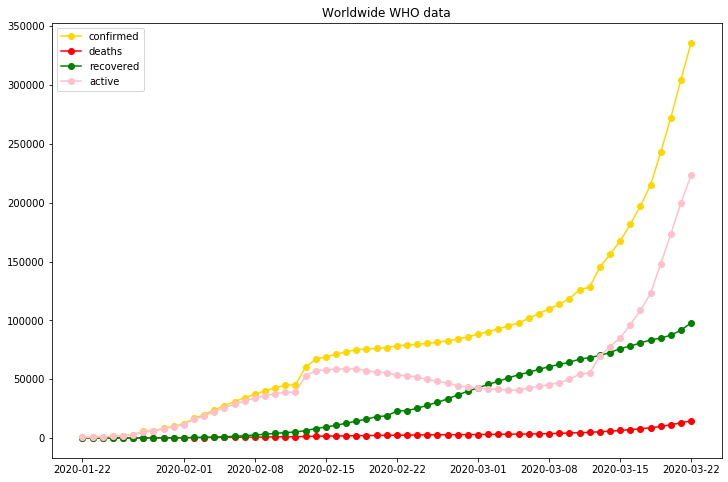

In [13]:
world_confirmed = []
world_deaths = []
world_recovered = []
world_active = []

for report in reports[:, 1]:
    world_stats = report.sum()
    world_confirmed.append(world_stats['Confirmed'])
    world_deaths.append(world_stats['Deaths'])
    world_recovered.append(world_stats['Recovered'])
    world_active.append(world_confirmed[-1] - world_deaths[-1] - world_recovered[-1])

fig, ax = plt.subplots(1, 1)
ax.set_title('Worldwide WHO data')
ax.plot(reports[:, 0], world_confirmed, 'o-', c='gold', label='confirmed')
ax.plot(reports[:, 0], world_deaths, 'o-', c='red', label='deaths')
ax.plot(reports[:, 0], world_recovered, 'o-', c='green', label='recovered')
ax.plot(reports[:, 0], world_active, 'o-', c='pink', label='active')
ax.legend()
plt.show()

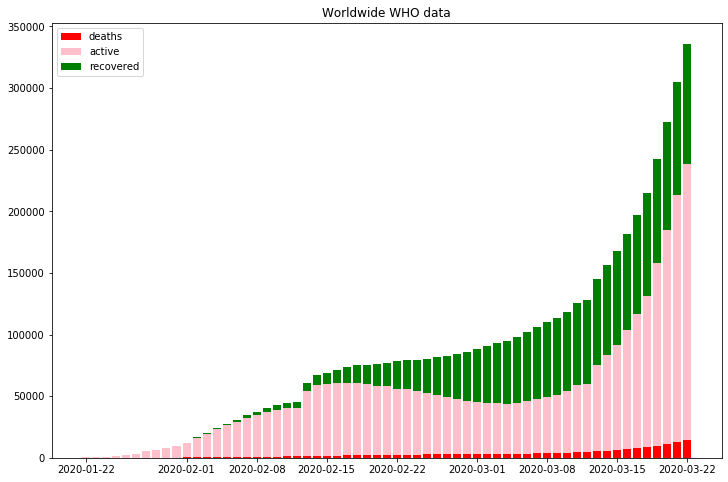

In [14]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Worldwide WHO data')
ax.bar(reports[:, 0], world_deaths, color='red', label='deaths')
ax.bar(reports[:, 0], world_active, color='pink', bottom=world_deaths, label='active')
active_and_deaths = np.array(world_active) + np.array(world_deaths)
ax.bar(reports[:, 0], world_recovered, color='green', bottom=active_and_deaths, label='recovered')
ax.legend()
plt.show()

## Ploting COVID data for certain regions

In [15]:
def plot_for_region(regions_list, plot_active=False, plot_confirmed=True):
    confirmed = []
    deaths = []
    recovered = []
    active = []

    for report in reports[:, 1]:
        region_aggregated_stats = report.groupby('Country/Region').sum()
        stats = region_aggregated_stats.reindex(regions_list).fillna(0).astype('int32').sum()
        confirmed.append(stats['Confirmed'])
        deaths.append(stats['Deaths'])
        recovered.append(stats['Recovered'])
        active.append(confirmed[-1] - deaths[-1] - recovered[-1])

    fig, ax = plt.subplots(1, 1)
    if len(regions_list) > 1:
        ax.set_title('WHO data for regions: ' + reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, regions_list, ""))
    else:
        ax.set_title('WHO data for the region ' + str(regions_list[0]))
                     
    if plot_confirmed:
        ax.plot(reports[:, 0], confirmed, 'o-', c='gold', label='confirmed')
    ax.plot(reports[:, 0], deaths, 'o-', c='red', label='deaths')
    ax.plot(reports[:, 0], recovered, 'o-', c='green', label='recovered')
    if plot_active:
        ax.plot(reports[:, 0], active, 'o-', c='pink', label='active')
    ax.legend()
    plt.show()

In [16]:
def barplot_for_region(regions_list):
    deaths = []
    recovered = []
    active = []

    for report in reports[:, 1]:
        region_aggregated_stats = report.groupby('Country/Region').sum()
        stats = region_aggregated_stats.reindex(regions_list).fillna(0).astype('int32').sum()
        deaths.append(stats['Deaths'])
        recovered.append(stats['Recovered'])
        active.append(stats['Confirmed'] - deaths[-1] - recovered[-1])

    fig, ax = plt.subplots(1, 1)
    if len(regions_list) > 1:
        ax.set_title('WHO data for regions: ' + reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, regions_list, ""))
    else:
        ax.set_title('WHO data for the region ' + str(regions_list[0]))

    ax.bar(reports[:, 0], deaths, color='red', label='deaths')
    ax.bar(reports[:, 0], active, color='pink', bottom=deaths, label='active')
    active_and_deaths = np.array(active) + np.array(deaths)
    ax.bar(reports[:, 0], recovered, color='green', bottom=active_and_deaths, label='recovered')

    ax.legend()
    plt.show()

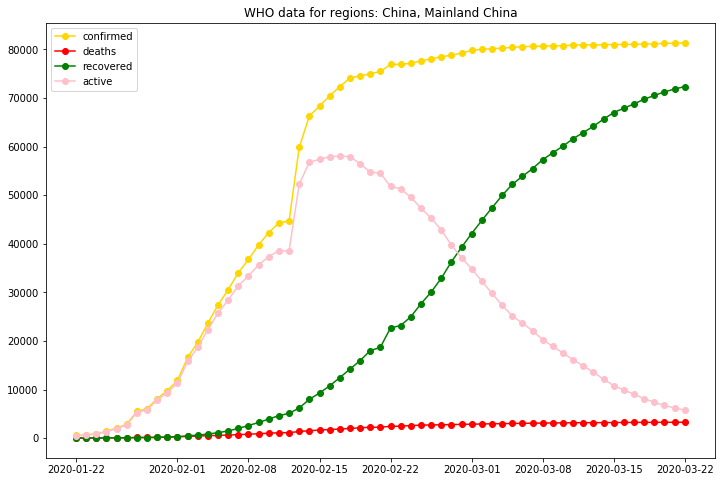

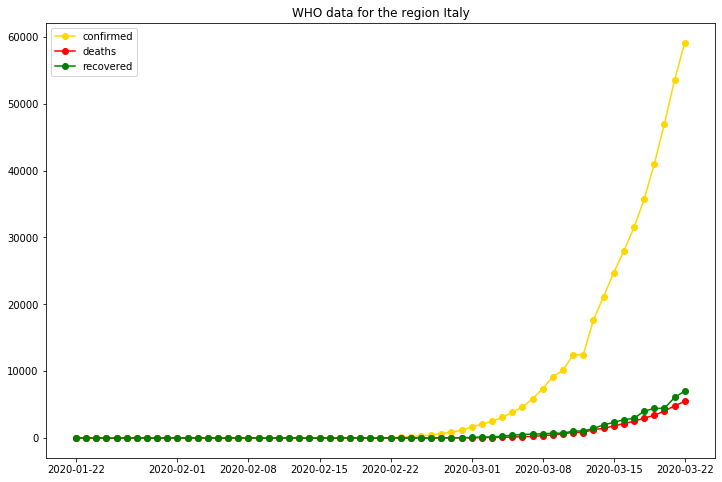

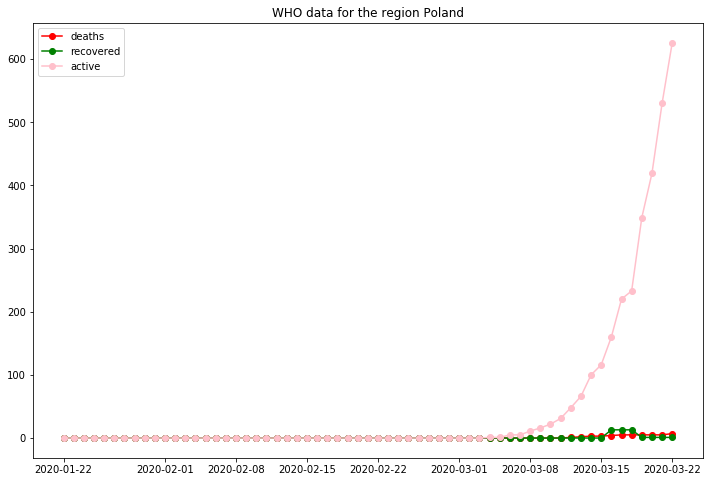

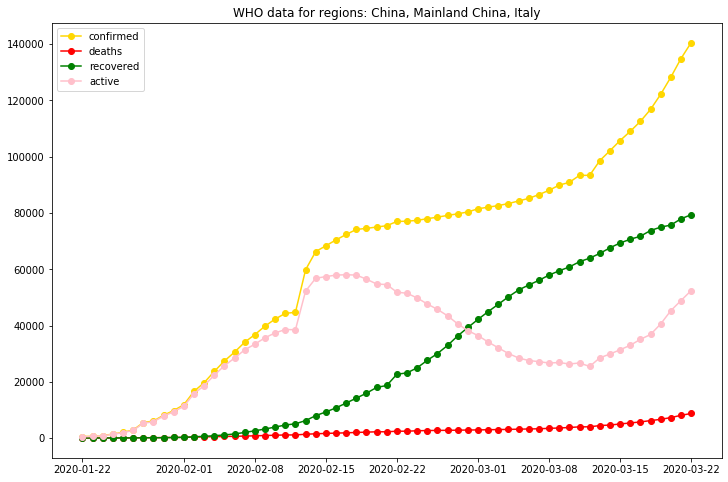

In [17]:
plot_for_region(['China', 'Mainland China'], plot_active=True)
plot_for_region(['Italy'])
plot_for_region(['Poland'], plot_active=True, plot_confirmed=False)
plot_for_region(['China', 'Mainland China', 'Italy'], plot_active=True)

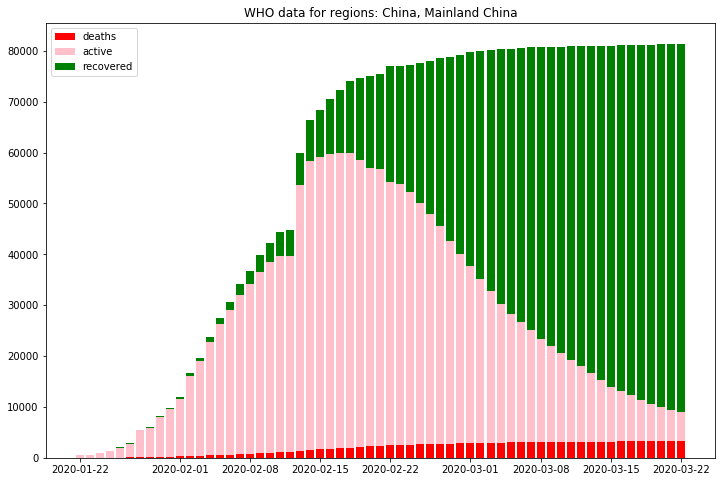

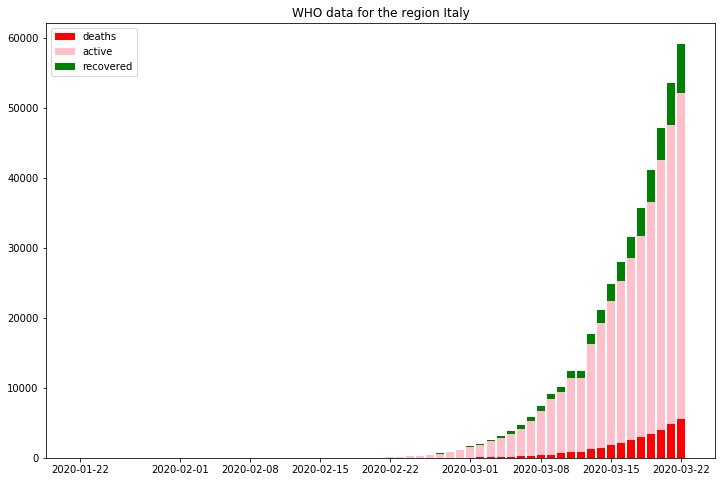

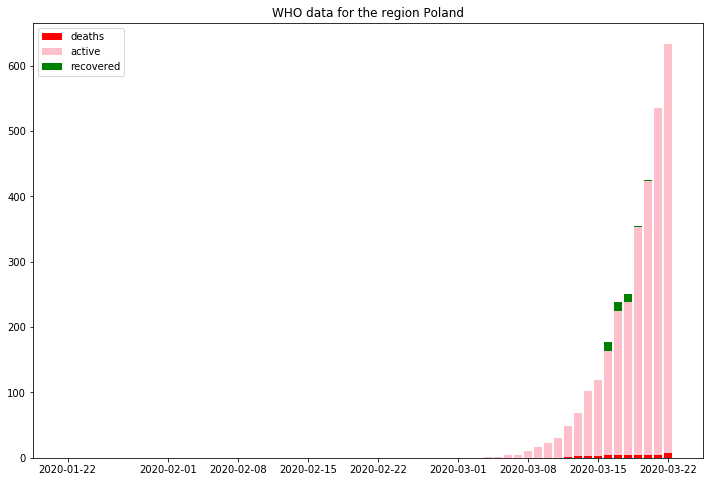

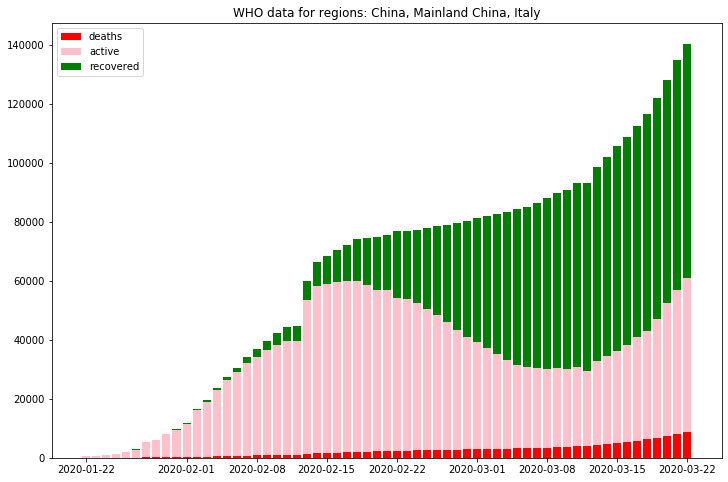

In [18]:
barplot_for_region(['China', 'Mainland China'])
barplot_for_region(['Italy'])
barplot_for_region(['Poland'])
barplot_for_region(['China', 'Mainland China', 'Italy'])

## Get geopandas world map dataframe

In [19]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


## Merge world map dataframe with latest WHO report dataframe

In [20]:
last_report = reports[-1][1].groupby("Country/Region", as_index=False).sum()
merged = world.join(last_report.set_index("Country/Region"), on="name")
# tmp fix, TODO create mapping betwen couries names in world map df and report df
merged.fillna(0, inplace=True)
merged.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Confirmed,Deaths,Recovered
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2.0,0.0,0.0
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",12.0,0.0,0.0
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.0,0.0,0.0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1465.0,21.0,10.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.0,0.0,0.0


## Plot number of confirmed cases on the world map

In [21]:
def plot_map(column_name, dataframe, title):
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '26'})
    dataframe.plot(column=column_name, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    plt.show()

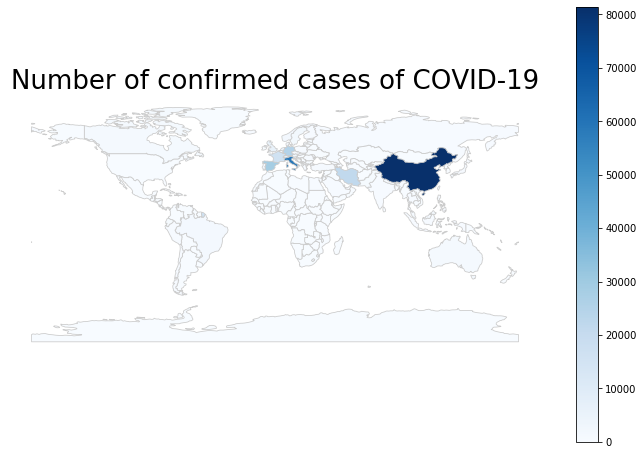

In [22]:
plot_map("Confirmed", merged, "Number of confirmed cases of COVID-19")   

## Plot number of confirmed cases on the Europe map (excluding Russia and French Guiana for clarity)

In [23]:
europe_stats_df = merged.loc[merged['continent'] == 'Europe', :].loc[merged['name'] != 'Russia', :]
france_geometry_values = europe_stats_df.loc[europe_stats_df['name'] == 'France', 'geometry'].values
france_geometry_values[0] = france_geometry_values[0][1:]
europe_stats_df.loc[europe_stats_df['name'] == 'France', 'geometry'] = france_geometry_values

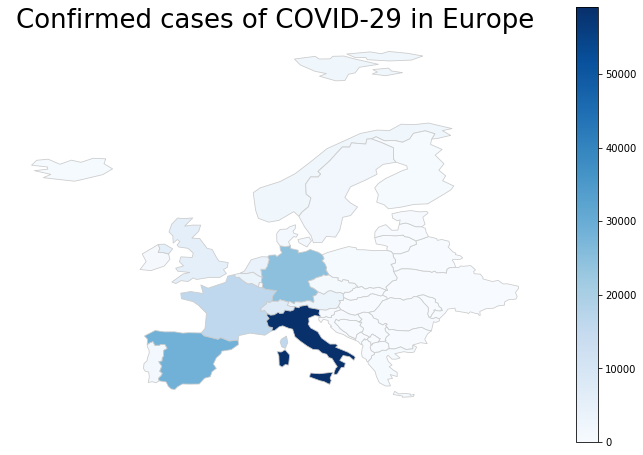

In [24]:
plot_map("Confirmed", europe_stats_df, "Confirmed cases of COVID-29 in Europe")

## Getting population dataframe (data from https://worldpopulationreview.com/)

In [25]:
population = pd.read_csv("popultion.csv")[['name', 'pop2020']]
population["pop2020"] *= 1000
population.head()

,name,pop2020
0,China,1.439324e+09
1,India,1.380004e+09
2,United States,3.310027e+08
3,Indonesia,2.735236e+08
4,Pakistan,2.208923e+08


In [26]:
# population of Poland
population.loc[population['name'] == 'Poland', "pop2020"].values[0]

37846611.0

In [27]:
last_report_with_population = last_report.join(population.set_index("name"), on='Country/Region')
# tmp fix, TODO create mapping betwen couries names in population df and report df
last_report_with_population = last_report_with_population.dropna(axis='index')
last_report_with_population

,Country/Region,Confirmed,Deaths,Recovered,pop2020
0,Afghanistan,40,1,1,38928346.0
1,Albania,89,2,2,2877797.0
2,Algeria,201,17,65,43851044.0
3,Andorra,113,1,1,77265.0
4,Angola,2,0,0,32866272.0
...,...,...,...,...,...
178,Uzbekistan,43,0,0,33469203.0
179,Venezuela,70,0,15,28435940.0
180,Vietnam,113,0,17,97338579.0
181,Zambia,3,0,0,18383955.0


In [28]:
last_report_with_percentage = last_report_with_population
last_report_with_percentage["Confirmed percentage"] = last_report_with_population["Confirmed"] / last_report_with_population["pop2020"]
last_report_with_percentage["Deaths percentage"] = last_report_with_population["Deaths"] / last_report_with_population["pop2020"]
last_report_with_percentage["Recovered percentage"] = last_report_with_population["Recovered"] / last_report_with_population["pop2020"]
last_report_with_percentage

,Country/Region,Confirmed,Deaths,Recovered,pop2020,Confirmed percentage,Deaths percentage,Recovered percentage
0,Afghanistan,40,1,1,38928346.0,1.027529e-06,2.568822e-08,2.568822e-08
1,Albania,89,2,2,2877797.0,3.092643e-05,6.949761e-07,6.949761e-07
2,Algeria,201,17,65,43851044.0,4.583699e-06,3.876761e-07,1.482291e-06
3,Andorra,113,1,1,77265.0,1.462499e-03,1.294247e-05,1.294247e-05
4,Angola,2,0,0,32866272.0,6.085266e-08,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
178,Uzbekistan,43,0,0,33469203.0,1.284763e-06,0.000000e+00,0.000000e+00
179,Venezuela,70,0,15,28435940.0,2.461674e-06,0.000000e+00,5.275015e-07
180,Vietnam,113,0,17,97338579.0,1.160896e-06,0.000000e+00,1.746481e-07
181,Zambia,3,0,0,18383955.0,1.631858e-07,0.000000e+00,0.000000e+00


In [29]:
max_infected = last_report_with_percentage.loc[last_report_with_percentage['Confirmed percentage'].idxmax(), :]
min_infected = last_report_with_percentage.loc[last_report_with_percentage['Confirmed percentage'].idxmin(), :]
print(f"Minimal procentage of population infected {min_infected['Country/Region']} - {min_infected['Confirmed percentage']}")
print(f"Maximal procentage of population infected {max_infected['Country/Region']} - {max_infected['Confirmed percentage']}")

Minimal procentage of population infected Cape Verde - 0.0
Maximal procentage of population infected San Marino - 0.004715451946597507


In [30]:
infected_map = world.join(last_report_with_percentage.set_index("Country/Region"), on="name")
# tmp fix, TODO create mapping betwen couries names in world map df and report df
infected_map.fillna(0, inplace=True)
infected_map.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Confirmed,Deaths,Recovered,pop2020,Confirmed percentage,Deaths percentage,Recovered percentage
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2.0,0.0,0.0,896445.0,2.231035e-06,0.000000e+00,0.000000e+00
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",12.0,0.0,0.0,59734218.0,2.008899e-07,0.000000e+00,0.000000e+00
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1465.0,21.0,10.0,37742154.0,3.881601e-05,5.564070e-07,2.649557e-07
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00


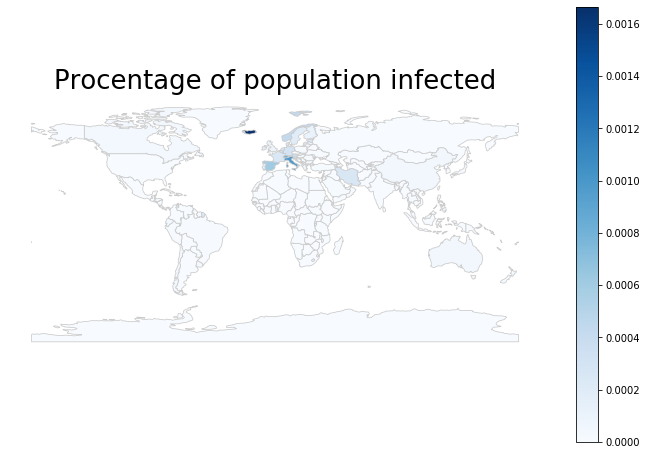

In [31]:
plot_map("Confirmed percentage", infected_map, "Procentage of population infected")

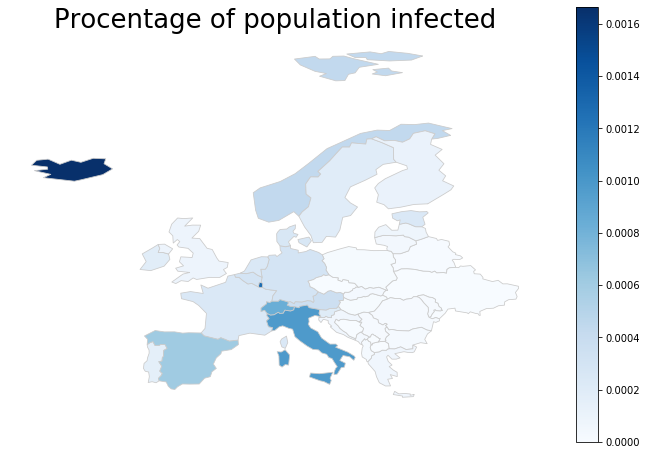

In [32]:
infected_europe = infected_map.loc[merged['continent'] == 'Europe', :].loc[merged['name'] != 'Russia', :]
france_geometry_values = infected_europe.loc[europe_stats_df['name'] == 'France', 'geometry'].values
france_geometry_values[0] = france_geometry_values[0][1:]
france_geometry_values[0]
infected_europe.loc[europe_stats_df['name'] == 'France', 'geometry'] = france_geometry_values
plot_map("Confirmed percentage", infected_europe, "Procentage of population infected")